In [41]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
devtools::load_all("../../hmmTMB")

ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Loading required package: TMB



In [42]:

# Metadata
symbols <- data.frame(
  name = c(
    "TSX_Composite", "Canada_Financials_Index", "Canada_Energy_Index",
    "Canada_Materials_Index", "Canada_Information_Technology_Index",
    "Canada_Utilities_Index", "Canada_Consumer_Staples_Index",
    "Canada_Real_Estate_Index", "Canada_Health_Care_Index",
    "Canada_Consumer_Discretionary_Index", "Canada_Corporate_Bonds",
    "Canada_Government_Bonds", "US_oil_gas", "Global_Materials",
    "US_Government_Bonds", "US_Real_Estate", "SP_500"
  ),
  etf_ticker = c(
    "XIC.TO", "XFN.TO", "XEG.TO", "XMA.TO", "XIT.TO", "XUT.TO",
    "XST.TO", "XRE.TO", "XHC.TO", "XMD.TO", "XCB.TO", "XGB.TO",
    "IEO", "MXI", "GOVT", "VNQ", "SPY"
  ),
  stringsAsFactors = FALSE
)

# Set date range
start <- as.Date("2019-01-01")
end <- as.Date("2025-01-01")  # Use current date for latest data

tickers <- symbols$etf_ticker
nice_names <- symbols$name

# Download daily data with error handling
stock_data <- list()
for (tk in tickers) {
  tryCatch({
    data <- getSymbols(tk, src = "yahoo", from = start, to = end, auto.assign = FALSE)
    # Clean timestamps to avoid fractional seconds
    index(data) <- as.Date(index(data))  # Convert to date-only
    stock_data[[tk]] <- data
  }, error = function(e) {
    message(sprintf("Failed to download data for %s: %s", tk, e$message))
  })
}

# Extract and combine Close prices from stock_data
close_data <- do.call(cbind, lapply(names(stock_data), function(tk) {
  x <- stock_data[[tk]]
  if (is.null(x) || !is.xts(x) || nrow(x) == 0) {
    message(sprintf("Skipping %s: Invalid or empty data.", tk))
    return(NULL)
  }
  # Find Close column (case-insensitive, handles variations like Adjusted.Close)
  close_col <- grep("Close", colnames(x), value = TRUE, ignore.case = TRUE)
  if (length(close_col) == 0) {
    message(sprintf("Skipping %s: No Close column found.", tk))
    return(NULL)
  }
  # Use the first matching Close column (e.g., prefer Adjusted.Close if available)
  close_col <- close_col[1]
  # Rename to ticker symbol
  colnames(x)[colnames(x) == close_col] <- tk
  return(x[, tk])
}))

# Remove NULL entries and check if any valid data remains
close_data <- close_data[, !sapply(close_data, is.null)]
if (ncol(close_data) == 0) stop("No valid Close data extracted.")

# Rename columns to friendly names
colnames(close_data) <- symbols$name[match(colnames(close_data), symbols$etf_ticker)]

# Filter to keep only the last day of each week
weekly_endpoints <- endpoints(close_data, on = "weeks", k = 1)
close_data <- close_data[weekly_endpoints, ]

# Verify that data remains after filtering
if (nrow(close_data) == 0) stop("No data remains after filtering to weekly endpoints.")

close_data <- data.frame(close_data)

dim(close_data)

[1] 314  17

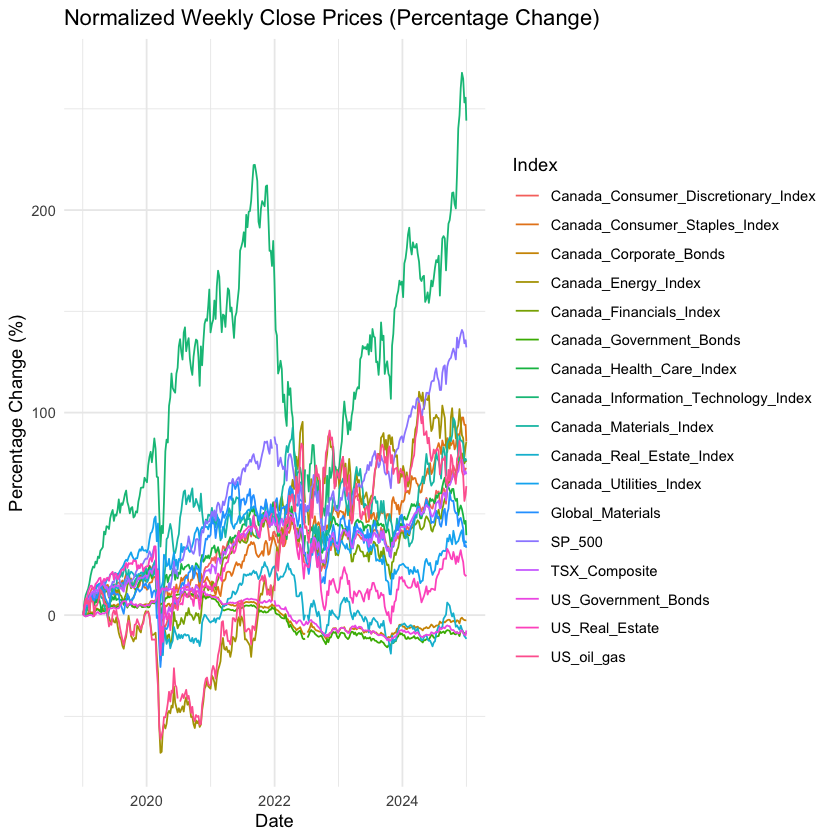

In [43]:
# Reshape data for ggplot
close_data_long <- close_data %>%
  mutate(Date = rownames(close_data)) %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100) %>%  # Normalize as percentage change
  mutate(Date = as.Date(Date))

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

In [44]:
cutoff <- as.Date('2024-01-01')
idx <- as.Date(rownames(close_data))
train <- close_data[idx <  cutoff, , drop = FALSE]
# Replace NAs in train with the last non-NA values
train <- na.locf(train, na.rm = FALSE)
test  <- close_data[idx >= cutoff, , drop = FALSE]
x_reg_cols <- setdiff(colnames(train), "TSX_Composite")
y_train <- train$TSX_Composite
y_test  <- test$TSX_Composite
xreg_train <- train[, x_reg_cols, drop = FALSE]
xreg_test  <- test[, x_reg_cols, drop = FALSE]
n_steps <- 5
n_states <- 2

In [46]:
## Create mega model with all stocks listed
## Naive model
formula <- as.formula(paste("~1 +",
  paste(colnames(close_data), collapse = " + "))
)
n_states <- 2
hid_model <- hmmTMB::MarkovChain$new(
  data = train,
  n_states = n_states,
  formula = formula,
  horseshoe = TRUE
)
obs_model <- hmmTMB::Observation$new(
    data = train,
    n_states = n_states,
    dists = list(TSX_Composite = "lnorm"),
    par = list(TSX_Composite = list(meanlog = c(0, 1), sdlog = c(1, 1))),
    # formula = list(TSX_Composite = list( mean =  ~TSX_lagged))
  )
hmm <- hmmTMB::HMM$new(hid = hid_model, obs = obs_model)

In [50]:
hmm$fit_stan(iter = 1000, warmup = 500, chains = 1, refresh = 0)

#######################
## Observation model ##
#######################
+ TSX_Composite ~ lnorm(meanlog, sdlog) 
  * meanlog.state1 ~ 1
  * meanlog.state2 ~ 1
  * sdlog.state1 ~ 1
  * sdlog.state2 ~ 1
 
#########################
## State process model ##
#########################
                                                                                                                                                                                                                                                                                                                                                                                                                          state 1
state 1                                                                                                                                                                                                                                                                                                      

ERROR: Error in args$laplace: object of type 'closure' is not subsettable


In [49]:
hmm$tmb_obj()

$par
     coeff_fe_obs      coeff_fe_obs      coeff_fe_obs      coeff_fe_obs 
         0.000000          1.000000          0.000000          0.000000 
     coeff_fe_hid      coeff_fe_hid      coeff_fe_hid      coeff_fe_hid 
        -2.197225          0.000000          0.000000          0.000000 
     coeff_fe_hid      coeff_fe_hid      coeff_fe_hid      coeff_fe_hid 
         0.000000          0.000000          0.000000          0.000000 
     coeff_fe_hid      coeff_fe_hid      coeff_fe_hid      coeff_fe_hid 
         0.000000          0.000000          0.000000          0.000000 
     coeff_fe_hid      coeff_fe_hid      coeff_fe_hid      coeff_fe_hid 
         0.000000          0.000000          0.000000          0.000000 
     coeff_fe_hid      coeff_fe_hid      coeff_fe_hid      coeff_fe_hid 
         0.000000          0.000000         -2.197225          0.000000 
     coeff_fe_hid      coeff_fe_hid      coeff_fe_hid      coeff_fe_hid 
         0.000000          0.000000          0